# Janssen & Rollins ABM

This project constitutes an attempt to replicate the ABM from the paper "Evolution of cooperation in asymmetric commons dilemmas" by Marco A. Janssen and Nathan D. Rollins (2011). 
See http://www.sciencedirect.com/science/article/pii/S0167268111002599 for the paper. 

This version is only preliminary and still at an early stage. The code has not yet been cleaned up completely and still contains some unnecessary variables and functions. This will be gradually improved during the next weeks.

## Basic Structure

This replication model relies on the Project Mesa Framework (see github.com/projectmesa).
To get an understanding of how an ABM is built with mesa, it is useful to start with the basic blocks: the Agent and Model classes. These are imported from the mesa module.

In [1]:
from mesa import Model, Agent

At the most basic level, an agent is initialized with a unique agent ID, and a variable where some information can be stored; as an example, each agent might have a score that is increased as the model runs.

In [2]:
class Resource_Agent(Agent):
    
     def __init__(self, unique_id):
        self.unique_id = unique_id
        self.score = 0

The Model class will later create a number of agents. To do this, both the number of agents and a function to create them will be needed:

In [3]:
class Resource_Model(Model):
    
    
    def __init__(self, N):
        self.num_agents = N
        self.create_agents()
        
    def create_agents(self):
        for i in range(self.num_agents):
            a = Resource_Agent(i)

The above already is sufficient to create a working model, although the created agents will not do anything yet. A model with 5 agents can be created and run as follows:

In [4]:
test_model_one = Resource_Model(5)
test_model_one.create_agents()

## Adding a Scheduler

In order to have the agents perform a certain action in each step of the model, a step function will have to be added to the Agent class. As an example, the agents will just increase their own score by 1 each round.

In the Model class, it will have to be defined in what order the agents are activated, and how the model behaves at each step. Mesa includes several schedules, AAAAthe simplest being the BaseScheduler - the agents are activated in the order they were created each round.

In [5]:
from mesa import Model, Agent
from mesa.time import RandomActivation

class Resource_Agent(Agent):
    
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.score = 0
        
    def step(self, model):
        self.score += 1

class Resource_Model(Model):
    
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.create_agents()
        
    def create_agents(self):
        for i in range(self.num_agents):
            a = Resource_Agent(i)
            self.schedule.add(a)
            
    def step(self):
        self.schedule.step()

    def run_model(self, steps):
        for i in range(steps):
            self.step()

This model can now be run, with 5 agents increasing their score each round, which will be repeated for 10 rounds.

In [6]:
model = Resource_Model(5)
model.create_agents()
model.run_model(10)

## Fitting the Model to Janssen & Rollins'

In order to recreate the desired model, Agent and Model class will have to be modified to fit Janssen&Rollins Public Resource Game. The model's structure with two sub-steps per round will require changes to the Scheduler class as well.
In this first approach, the algorithm by which agents respond to each other will be omitted, and a contribution and share takeout level will be chosen at random. [Note that this is equivalent to including the algorithm as described by formula 4 in J&R's paper and setting the parameter eta to 0. For values other than zero, the expected utility for each level of contribution will be taken into account.]

### Agent Class

In the game's first round, each agent is endowed with a certain number of tokens (10), some of which can be contributed to the common public resource (CPR). Depending on the amount of contributions, this resource will be multiplied by some factor. In the second round, the agents take turns taking out some share of the CPR - the first agent gets to pick first, and so forth, until the last agent. Each step, contribution and takeout share will be chosen at random. The agents store the tokens they acquired during the game in a score variable.

In [7]:
import random
from mesa import Model, Agent

class Resource_Agent(Agent):

    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.score = 0
        self.endowment = 10
        self.contribution = random.randrange(0, 10, 1)
        self.takeout_share = (random.randrange(0, 10, 1)) / 10
        
    def first_round(self, model):
        self.endowment = 10
        self.contribution = random.randrange(0, 10, 1)
        self.score += (self.endowment - self.contribution)
        model.sum_of_contributions += self.contribution
        
    def second_round(self, model):
        self.takeout_share = (random.randrange(0, 10, 1)) / 10
        takeout = round(model.resource * self.takeout_share)
        self.score += takeout
        model.resource -= takeout

### Model Class

The model class will determine the amount of tokens currently in the CPR, create a number of agents, and run for a number of steps. Janssen&Rollins describe an S-shaped function for the generated resource: more than one contributing agent is necessary to create a CPR. Mesa features a class for data colletion - this will be used to visualize the model's outcome in the end.

In [8]:
from mesa.datacollection import DataCollector

class Resource_Model(Model):
    
    def __init__(self, N):
        self.num_agents = N
        self.schedule = BaseScheduler(self)
        self.create_agents()
        self.resource = 0
        #creating a variable to determine the amount of CPR generated in this round:
        self.sum_of_contributions = 0
        #data collector
        ar = {"Score": lambda ar: ar.score}
        self.dc = DataCollector(agent_reporters = ar)
        
    def create_agents(self):            
        for i in range(self.num_agents):
            a = Resource_Agent(i)
            self.schedule.add(a)
            
    def step(self):
        self.schedule.step()
        #collecting data
        self.dc.collect(self)
        #resetting the sum of contributions needed to determine the amount of CPR:
        self.sum_of_contributions = 0
        
    def run_model(self, steps):
        for i in range(steps):
            self.step()
            
    def created_resource(self, sum_of_contributions):
        if sum_of_contributions >= 0 and sum_of_contributions <= 10:
            produced_resource = 0
        elif sum_of_contributions >10 and sum_of_contributions <= 15:
            produced_resource = 5
        elif sum_of_contributions >15 and sum_of_contributions <= 20:
            produced_resource = 20
        elif sum_of_contributions >20 and sum_of_contributions <= 25:
            produced_resource = 40
        elif sum_of_contributions >25 and sum_of_contributions <= 30:
            produced_resource = 60
        elif sum_of_contributions >30 and sum_of_contributions <= 35:
            produced_resource = 75
        elif sum_of_contributions >35 and sum_of_contributions <= 40:
            produced_resource = 85
        elif sum_of_contributions >40 and sum_of_contributions <= 45:
            produced_resource = 95
        elif sum_of_contributions >45 and sum_of_contributions <= 50:
            produced_resource = 100
        return produced_resource

### Scheduler

Due to the Model's design with two rounds in each step, the scheduler class needs to be modified. Also, after each first round, the model's created_resource() function will be called to determine the amount of CPR generated.

In [9]:
class BaseScheduler(object):
    model = None
    steps = 0
    time = 0
    agents = []

    def __init__(self, model):
        self.model = model
        self.steps = 0
        self.time = 0
        self.agents = []

    def add(self, agent):
        self.agents.append(agent)

    def remove(self, agent):
        while agent in self.agents:
            self.agents.remove(agent)

    def step(self):
    #Modified part.
        for agent in self.agents:
            agent.first_round(self.model)
        self.model.resource = self.model.created_resource(self.model.sum_of_contributions)
        for agent in self.agents:            
            agent.second_round(self.model)
        self.steps += 1
        self.time += 1

    def get_agent_count(self):
        return len(self.agents)

As before, this model will now be run for 10 steps including 5 agents:

In [10]:
agents = 5
runs = 10

test_model = Resource_Model(agents)
test_model.run_model(runs)

Since the data collector collects data on each agents score, the scores of the five agents can be shown in a table using matplotlib.

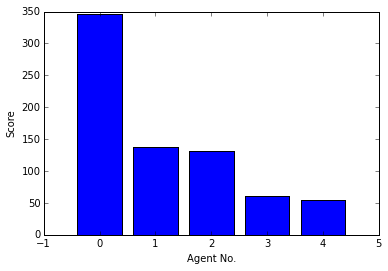

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

data = test_model.dc.get_agent_vars_dataframe()
data.reset_index(inplace=True)
last_step_data = data[data.Step == (runs - 1)]

x = range(agents)
plt.ylabel("Score")
plt.xlabel("Agent No.")
plt.bar(x, last_step_data.Score, align = "center")
plt.show()

## Algorithm

The model as described above is running like Janssen&Rollins' model in its basic structure, but since all moves are selected from a uniform random distribution, no useful data can be generated. To recreate the probabilistic choice function by which agents react to each other in the original model, more functions need to be implemented. This is done mainly in the Agent class; the Model class remains unchanged in its essential features.

### Modifications to the Agent class

As a first step, the model needs to be initialized with additional variables to store the model's parameters: alpha, beta and eta. Contribution and Takeout share in the game's first step remain uniformly random for now.

In [12]:
from mesa import Model, Agent

class Resource_Agent(Agent):

    def __init__(self, unique_id, alpha, beta, eta):
        self.unique_id = unique_id
        self.score = 0
        self.endowment = 10
        self.contribution = random.randrange(0, 10, 1)
        self.takeout_share = (random.randrange(0, 10, 1)) / 10
        self.alpha = alpha
        self.beta = beta
        self.eta = eta

In the first_round and second_round functions, a list of probabilities from which a move is chosen replaces the uniformly random move choice. This list of probabilities is the heart of the model. It will be shown later how this list is generated.

In [13]:
    def first_round(self, model):
        self.endowment = 10
        self.contribution = np.random.choice(11, p = self.k_probability_list_function(model))
        self.score += (self.endowment - self.contribution)
        model.sum_of_contributions += self.contribution
        
    def second_round(self, model):
        self.takeout_share = ((np.random.choice(11, p = self.l_probability_list_function(mode)) / 10))
        takeout = round(model.resource * self.takeout_share)
        self.score += takeout
        model.resource -= takeout

#### First Round

In the model, a hypothetical utility for each possible amount of contribution to the CPR is calculated, dependent on the choices of Contribution and Share Takeout level of the other agents in the previous round. The utility of each k is "transformed" and divided by the sum of the "transformed" utilities for all ks. The transformation is done by multiplying the utility by the model parameter eta, and calculating the exponential function for this - 
See formula (4) in the Janssen&Rollins paper. 
Note that the following functions will later need to be reversed in order to make them callable for each other, but the approach is more easily understandable by introducing them in reverse order.

In [14]:
    def k_probability_list_function(self, model):
        probability_list = []
        for i in range(0, 11, 1):
            probability_list.append(self.probability_of_k(i, model))
        return probability_list
    
    def probability_of_k(k, model):
        utility_of_k = self.utility_transformation(k, model)
        probability = utility_of_k / self.transformed_utility_sum(model)
        return probability
    
    def utility_transformation(self, k, model):
        transformed_utility = math.exp(self.eta * (self.utility_of_k(k, model)))
        return transformed_utility
    
    def transformed_utility_sum(self, model):
        utility_sum = 0
        for i in range(0, 11, 1):
            calculation = self.utility_transformation(i, model)
            utility_sum += calculation
        return utility_sum   

For a given hypothetical utility for each k, each agent could now pick a contribution by probabilistic choice. In order for this to work, functions to determine hypothetical utilites for each k given the previous round's contributions and takeout shares of the other agents.
The utility is dependend on an agent's earnings, the parameters alpha and beta, and the average earnings of the other players. See formula (3) in the J&R paper for this.

In [15]:
    def utility_of_k(self, k, model):
        if self.determine_wage(k, model) > self.determine_average_wage(k, model):
            utility = self.determine_wage(k, model) - (self.alpha * (self.determine_wage(k, model) - self.determine_average_wage(k, model)))
        elif self.determine_wage(k, model) == self.determine_average_wage(k, model):
            utility = self.determine_wage(k, model)
        else:
            utility = self.determine_wage(k, model) + (self.beta * (self.determine_average_wage(k, model) - self.determine_wage(k, model)))
        return utility

In order to calculate the utility, additional functions to determine the wages for each respective player, as well as the average wage are needed. As follows from formula (4), the hypothetical wage for each contribution level k is dependent on the CPR that would be generated if all agents contributed the same amount as in the previous round, and the agent's upstream agents took out the same share as in the previous round - that is, the agent's potential takeout from the CPR.

In [16]:
    def determine_wage(self, k, model):
        wage_player = (self.endowment - k) + self.determine_available_resource(k, model)
        return wage_player

As mentioned, the potentially available resource is determined by the CPR generated by all other agents - upstream and downstream - and the takeout share of the other players. The generated CPR is subject to the S-curve transformation described earlier, which is stored in the model class.

In [17]:
    def determine_available_resource(self, k, model):
        contributions = self.last_round_sum_of_other_contributions(model) + k
        resource = model.created_resource(contributions)
        available_resource = resource * self.last_round_upstream_agents_combined_takeout_shares(model)
        return available_resource

In order to make the abovewritten function work, a function to determine the other agents and their position respective to the relevant agent are necessary.
Then, functions to determine a given agent's last contribution and takeout level need to be added.
In order for both to work, some additional variables in the agent class are added.
The class is to be initialised with two new variables: a list for the agent's contributions in previous steps, past_contributions, and a list for the agent's takeout shares in past steps, past_takeout_shares.
Two extra variables storing the total amount of tokens contributed to and taken out of the CPR will be added for the purpose of later data extraction.
We will later utilize numpy to pick a move at random from a given list of probabilities, and using a math function to do a transformation of the utility.

In [18]:
import math
import numpy as np


class Resource_Agent(Agent):

    def __init__(self, unique_id, alpha, beta, eta):
        self.unique_id = unique_id
        self.score = 0
        self.endowment = 10
        self.contribution = random.randrange(0, 10, 1)
        self.takeout_share = (random.randrange(0, 10, 1)) / 10
        self.alpha = alpha
        self.beta = beta
        self.eta = eta
        #New variables
        self.past_contributions = [self.contribution]
        self.past_takeout_shares = [self.takeout_share]
        self.total_contribution = 0
        self.total_amount_taken_out = 0

These variables need to be appended with the agent's contribution and takeout shares for each step. Also, the total_contribution and total_amount_taken_out variables are updated each round.

In [19]:
    def first_round(self, model):
        self.endowment = 10
        self.contribution = np.random.choice(11, p = self.k_probability_list_function(model))
        self.score += (self.endowment - self.contribution)
        model.sum_of_contributions += self.contribution
        #Appending the past_contributions list
        self.past_contributions.append(self.contribution)
        #Increasing the total contributions
        self.total_contribution += self.contribution
        
    def second_round(self, model):
        self.takeout_share = ((np.random.choice(11, p = self.l_probability_list_function(model)) / 10))
        takeout = round(model.resource * self.takeout_share)
        self.score += takeout
        model.resource -= takeout
        #Appending the past_takeout_shares list
        self.past_takeout_shares.append(self.takeout_share)
        #Increasing the total amount taken out
        self.total_amount_taken_out += takeout

A function to determine a list of upstream and downstream agents is added. First, each agent needs to be able to determine its own ID.

In [20]:
    def get_id(self):
        return self.unique_id        
    
    def determine_upstream_players(self, model):
        
        upstream_players = []
        for agent in model.schedule.agents:
            if agent.unique_id < self.get_id():
                upstream_players.append(agent)
        return upstream_players
    
    def determine_downstream_players(self, model):
        
        downstream_players = []
        for agent in model.schedule.agents:
            if agent.unique_id > self.get_id():
                downstream_players.append(agent)
        return downstream_players

Now, let's add functions for determining the sum of all other agents' contributions in the previous step of the game.

In [21]:
    def last_round_sum_of_other_players_contributions(self, model):
        sum_of_contributions = 0
        for i in self.determine_upstream_players(model):
            sum_of_contributions += i.past_contributions[model.schedule.steps]
        for j in self.determine_downstream_players(model):
            sum_of_contributions += j.past_contributions[model.schedule.steps]
        return sum_of_contributions

Finally, the previous round's takeout shares need to be combined - but only for the agents upstream of the respective agents. Also, this is not a sum of shares, but a multiplication of them, since the shares are expressed in a fraction of the total resource that is taken out. To get the remaining share, the term has to be muliplied by (1 - share) for each agent.

In [22]:
    def last_round_upstream_agents_combined_takeout_shares(self, model):
        remaining_share = 1
        for i in self.determine_upstream_players(model):
            remaining_share = remaining_share * (1 - i.past_takeout_shares[model.schedule.steps])
        return remaining_share

A given agent's wage can now be determined! Let's move on to the next part of the utility function, the average wage, which is equal to the amount of CPR that was generated plus the part of the endowment that was not invested - divided by the amount of agents. This calculation is based on the assumption that none of the CPR is "wasted", i.e., not taken out - which should be the case.

In [23]:
    def determine_average_wage(self, k, model):
        n = 0
        for i in model.schedule.agents:
            n += 1
        generated_cpr = model.created_resource(self.last_round_sum_of_other_contributions(model) + k)
        endowment_not_invested = (n * self.endowment) - (self.last_round_sum_of_other_contributions(model) + k)
        total_wage = generated_cpr + endowment_not_invested
        average_wage = total_wage / n
        
        return average_wage

Which allows a calculation of the utility for each given k, and thus gives a list of probabilities for each k. What remains to be added is an analoguous algorithm for determining the takeout share, l. This is equivalent to function (5) in the paper.

#### Second Round

In [24]:
    def l_probability_list_function(self, model):
        l_probability_list = []
        for i in range(0, 11, 1):
            l_probability_list.append(self.probability_of_l(i / 10, model))
        return l_probability_list
    
    def probability_of_l(self, l, model):
        utility_of_l = self.round_two_utility_transformation(l, model)
        probability_of_l = utility_of_l / self.round_two_transformed_utility_sum(model)
        return probability_of_l
    
    def round_two_utility_transformation(self, l, model):
        round_two_transformed_utility = math.exp(self.eta * (self.determine_round_two_utility(l, model)))
        return round_two_transformed_utility
    
    def round_two_transformed_utility_sum(self, model):
        round_two_utility_sum = 0
        for i in range(0, 11, 1):
            calculation = self.round_two_utility_transformation(i / 10, model)
            round_two_utility_sum += calculation
        return round_two_utility_sum

Equivalently to the first round, a function to determine a hypothetical utility for each takeout share l is needed. Unlike in the first round, however, the takeout shares of the upstream agents are known to the calculating agent, as is the size of the resource.

In [25]:
    def determine_round_two_utility(self, l, model):
        
        if self.round_two_determine_wage(l, model) > self.round_two_average_wage(l, model):
            utility = self.round_two_determine_wage(l, model) - (self.alpha * (self.round_two_determine_wage(l, model) - self.round_two_average_wage(l, model)))
        elif self.round_two_determine_wage(l, model) == self.round_two_average_wage(l, model):
            utility = self.round_two_determine_wage(l, model)
        else:
            utility = self.round_two_determine_wage(l, model) + (self.beta * (self.round_two_average_wage(l, model) - self.round_two_determine_wage(l, model)))
        return utility

    def round_two_determine_wage(self, l, model):
        round_two_wage = (self.endowment - self.contribution) + (l * model.resource)
        return round_two_wage
     
    def round_two_average_wage(self, l, model):
        n = 0
        for i in model.schedule.agents:
            n += 1
        this_round_contribution_sum = 0
        for i in model.schedule.agents:
            this_round_contribution_sum += i.contribution
        generated_resource = model.created_resource(this_round_contribution_sum)
        endowment_not_invested = (n * self.endowment) - this_round_contribution_sum
        total_wage = generated_cpr + endowment_not_invested
        average_wage = total_wage / n

#### Complete Agent class

The necessary functions and variables to incorporate the algorithm into the Agent class are thus added. As mentioned earlier, the order in which the functions are defined need to be reversed, in order to make them callable in the right order. Which leaves us with the following complete Agent class:

In [26]:
class Resource_Agent(Agent):

    def __init__(self, unique_id, alpha, beta, eta):
        self.unique_id = unique_id
        self.score = 0
        self.endowment = 10
        self.contribution = random.randrange(0, 10, 1)
        self.takeout_share = (random.randrange(0, 10, 1)) / 10
        self.alpha = alpha
        self.beta = beta
        self.eta = eta
        self.past_contributions = [self.contribution]
        self.past_takeout_shares = [self.takeout_share]
        self.total_contribution = 0
        self.total_amount_taken_out = 0
        
    def first_round(self, model):
        self.endowment = 10
        self.contribution = np.random.choice(11, p = self.k_probability_list_function(model))
        self.score += (self.endowment - self.contribution)
        self.past_contributions.append(self.contribution)
        self.total_contribution += self.contribution
        model.sum_of_contributions += self.contribution
        #Needed later for the BatchRunner
        model.total_endowment_not_invested += (self.endowment - self.contribution)
        
    def second_round(self, model):
        self.takeout_share = ((np.random.choice(11, p = self.l_probability_list_function(model)) / 10))
        takeout = round(model.resource * self.takeout_share)
        self.score += takeout
        model.resource -= takeout
        self.past_takeout_shares.append(self.takeout_share)
        self.total_amount_taken_out += takeout  
        
    #General functions
    
    def get_id(self):
        return self.unique_id        

    def determine_upstream_players(self, model):
        
        upstream_players = []
        for agent in model.schedule.agents:
            if agent.unique_id < self.get_id():
                upstream_players.append(agent)
        return upstream_players
    
    def determine_downstream_players(self, model):
        
        downstream_players = []
        for agent in model.schedule.agents:
            if agent.unique_id > self.get_id():
                downstream_players.append(agent)
        return downstream_players
    
    #Functions for Round 1
    
    def last_round_sum_of_other_contributions(self, model):
        sum_of_contributions = 0
        for i in self.determine_upstream_players(model):
            sum_of_contributions += i.past_contributions[model.schedule.steps]
        for j in self.determine_downstream_players(model):
            sum_of_contributions += j.past_contributions[model.schedule.steps]
        return sum_of_contributions
    
    def last_round_upstream_agents_combined_takeout_shares(self, model):
        remaining_share = 1
        for i in self.determine_upstream_players(model):
            remaining_share = remaining_share * (1 - i.past_takeout_shares[model.schedule.steps])
        return remaining_share
    
    def determine_available_resource(self, k, model):
        contributions = self.last_round_sum_of_other_contributions(model) + k
        resource = model.created_resource(contributions)
        available_resource = resource * self.last_round_upstream_agents_combined_takeout_shares(model)
        return available_resource
    
    def determine_wage(self, k, model):
        wage_player = (self.endowment - k) + self.determine_available_resource(k, model)
        return wage_player
    
    def determine_average_wage(self, k, model):
        n = 0
        for i in model.schedule.agents:
            n += 1
        generated_cpr = model.created_resource(self.last_round_sum_of_other_contributions(model) + k)
        endowment_not_invested = (n * self.endowment) - (self.last_round_sum_of_other_contributions(model) + k)
        total_wage = generated_cpr + endowment_not_invested
        average_wage = total_wage / n
        return average_wage
    
    def utility_of_k(self, k, model):
        if self.determine_wage(k, model) > self.determine_average_wage(k, model):
            utility = self.determine_wage(k, model) - (self.alpha * (self.determine_wage(k, model) - self.determine_average_wage(k, model)))
        elif self.determine_wage(k, model) == self.determine_average_wage(k, model):
            utility = self.determine_wage(k, model)
        else:
            utility = self.determine_wage(k, model) + (self.beta * (self.determine_average_wage(k, model) - self.determine_wage(k, model)))
        return utility
    
    def utility_transformation(self, k, model):
        transformed_utility = math.exp(self.eta * (self.utility_of_k(k, model)))
        return transformed_utility

    def transformed_utility_sum(self, model):
        utility_sum = 0
        for i in range(0, 11, 1):
            calculation = self.utility_transformation(i, model)
            utility_sum += calculation
        return utility_sum   
    
    def probability_of_k(self, k, model):
        utility_of_k = self.utility_transformation(k, model)
        probability = utility_of_k / self.transformed_utility_sum(model)
        return probability
    
    def k_probability_list_function(self, model):
        probability_list = []
        for i in range(0, 11, 1):
            probability_list.append(self.probability_of_k(i, model))
        return probability_list
    
    #Functions for Round 2
    
    def round_two_determine_wage(self, l, model):
        round_two_wage = (self.endowment - self.contribution) + (l * model.resource)
        return round_two_wage
     
    def round_two_average_wage(self, l, model):
        n = 0
        for i in model.schedule.agents:
            n += 1
        this_round_contribution_sum = 0
        for i in model.schedule.agents:
            this_round_contribution_sum += i.contribution
        generated_resource = model.created_resource(this_round_contribution_sum)
        endowment_not_invested = (n * self.endowment) - this_round_contribution_sum
        total_wage = generated_resource + endowment_not_invested
        average_wage = total_wage / n
        return average_wage
    
    def determine_round_two_utility(self, l, model):
        if self.round_two_determine_wage(l, model) > self.round_two_average_wage(l, model):
            utility = self.round_two_determine_wage(l, model) - (self.alpha * (self.round_two_determine_wage(l, model) - self.round_two_average_wage(l, model)))
        elif self.round_two_determine_wage(l, model) == self.round_two_average_wage(l, model):
            utility = self.round_two_determine_wage(l, model)
        else:
            utility = self.round_two_determine_wage(l, model) + (self.beta * (self.round_two_average_wage(l, model) - self.round_two_determine_wage(l, model)))
        return utility

    def round_two_utility_transformation(self, l, model):
        round_two_transformed_utility = math.exp(self.eta * (self.determine_round_two_utility(l, model)))
        return round_two_transformed_utility
    
    def round_two_transformed_utility_sum(self, model):
        round_two_utility_sum = 0
        for i in range(0, 11, 1):
            calculation = self.round_two_utility_transformation(i / 10, model)
            round_two_utility_sum += calculation
        return round_two_utility_sum

    def probability_of_l(self, l, model):
        utility_of_l = self.round_two_utility_transformation(l, model)
        probability_of_l = utility_of_l / self.round_two_transformed_utility_sum(model)
        return probability_of_l


    def l_probability_list_function(self, model):
        l_probability_list = []
        for i in range(0, 11, 1):
            l_probability_list.append(self.probability_of_l(i / 10, model))
        return l_probability_list

### Modifications to the Model class

Inside the Model class, additional variables to pass on the parameters to the Agent class are the only modification. Also, the DataCollector will be updated in order to collect the total amount of contributions and takeouts for each agent.

In [27]:
class Resource_Model(Model):
    
    def __init__(self, N, alpha, beta, eta):
        self.num_agents = N
        self.alpha = alpha
        self.beta = beta
        self.eta = eta
        self.schedule = BaseScheduler(self)
        self.create_agents()
        self.resource = 0
        self.sum_of_contributions = 0
        ar = {"Score": lambda ar: ar.score, 
                "Total_Contribution": lambda at: at.total_contribution, 
                "Total_Amount_Taken_Out": lambda au: au.total_amount_taken_out}
        self.dc = DataCollector(agent_reporters = ar)
        # Variables needed for the BatchRunner to work later
        self.total_produced_resource = 0
        self.total_endowment_not_invested = 0
        # Additional Model DataCollector later needed for the BatchRunner to work
        ad = {"Total_Payoff": lambda ad: ad.total_produced_resource}
        self.dci = DataCollector(model_reporters = ad)
        self.running = True

        
    def create_agents(self):            
        for i in range(self.num_agents):
            a = Resource_Agent(i, alpha, beta, eta)
            self.schedule.add(a)
            
    def step(self):
        self.schedule.step()
        self.dc.collect(self)
        self.total_produced_resource += self.created_resource(self.sum_of_contributions)
        self.sum_of_contributions = 0
        
    def run_model(self, steps):
        for i in range(steps):
            self.step()
            
    #Function needed for the BatchRunner to work later
    def determine_total_payoff(self):
        total_payoff = self.total_produced_resource + self.total_endowment_not_invested
        return total_payoff
            
    def created_resource(self, sum_of_contributions):
        if sum_of_contributions >= 0 and sum_of_contributions <= 10:
            produced_resource = 0
        elif sum_of_contributions >10 and sum_of_contributions <= 15:
            produced_resource = 5
        elif sum_of_contributions >15 and sum_of_contributions <= 20:
            produced_resource = 20
        elif sum_of_contributions >20 and sum_of_contributions <= 25:
            produced_resource = 40
        elif sum_of_contributions >25 and sum_of_contributions <= 30:
            produced_resource = 60
        elif sum_of_contributions >30 and sum_of_contributions <= 35:
            produced_resource = 75
        elif sum_of_contributions >35 and sum_of_contributions <= 40:
            produced_resource = 85
        elif sum_of_contributions >40 and sum_of_contributions <= 45:
            produced_resource = 95
        elif sum_of_contributions >45 and sum_of_contributions <= 50:
            produced_resource = 100
        return produced_resource

### Running the Algorithm Model

The model now being on par with the model in J&R's paper, it can now be run with specified parameters. The parameters alpha, beta, and eta will all be set 0.5 for now.

In [28]:
#Model Parameters
runs = 10
agents = 5
alpha = 0.5
beta = 0.5
eta = 0.5
#Run the Model
test_model = Resource_Model(agents, alpha, beta, eta)
test_model.run_model(runs)

To analyze the model's output, a plot showing the total amount of contributions and takeouts for each player will be drawn. For this, first, the relevant data points in the DataCollector's data array need to be extracted: For the total contribution and takeouts, only the very last step of the game is relevant.

In [29]:
data = test_model.dc.get_agent_vars_dataframe()
data.reset_index(inplace=True)

model_data = test_model.dc.get_model_vars_dataframe()

last_step_data = data[data.Step == (runs -1 )]

Now, the diagram is plotted, using matplotlib.

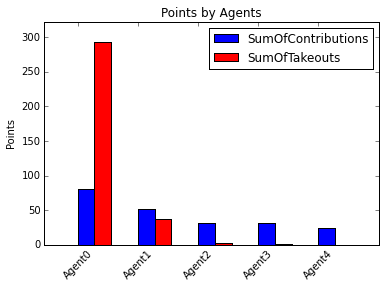

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

N = agents
ind = np.arange(N)
width = 0.28
player_one = last_step_data[last_step_data.AgentID == 0]
highest_takeout = int(player_one.Total_Amount_Taken_Out)


rects1 = ax.bar(ind + width * 2, last_step_data.Total_Amount_Taken_Out, width, color = "red")
rects2 = ax.bar(ind + width, last_step_data.Total_Contribution, width, color = "blue")

ax.set_xlim(-width, len(ind) + width)
ax.set_ylim(0, highest_takeout * 1.1)
ax.set_ylabel("Points")
ax.set_title("Points by Agents")
xTickMarks = ["Agent" + str(i) for i in range(agents)]
ax.set_xticks(ind + width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation = 45, fontsize = 10)

ax.legend((rects2[0], rects1[0]), ("SumOfContributions", "SumOfTakeouts"))
plt.show()

## BatchRunner

J&R's model includings alpha and beta as modifiable parameters. In order to get meaningful results on how these parameters change the outcome of the model, it will be necessary to run the model with multiple combinations of the parameters - multiple times, as the model includes a stochastic element. This can be done conveniently with mesa's BatchRunner class, which is to be imported.

In [31]:
from mesa.batchrunner import BatchRunner

The most interesting result from the model is how the parameters alpha and beta, and the total amount of payoff for all the agents in the model relate. For the total payoff, some modifications to the Model class need to be made, and a function is to be added. In order to determinate the total payoff, the two additional variables total_produced_resource, total_sum_of_contributions, and the function determine_total_payoff are now needed.

In [32]:
def determine_total_payoff(model):
    total_payoff = model.determine_total_payoff()
    return total_payoff

First, a range of values for alpha and beta with which to run the Batch is defined, as well as a number of iterations for which to run each combination of alpha and beta:

In [33]:
alpha_values = []
for i in range(7, 11):
    x = i/10
    alpha_values.append(x)

beta_values = []
for i in range(7, 11):
    x = i/10
    beta_values.append(x)

iterations = 5

Now, the BatchRunner can be set up.

In [34]:
model = Resource_Model(agents, alpha, beta, eta)   
param_values = {"N": 5, "alpha": alpha_values, "beta": beta_values, "eta": 0.5}
model_reporter = {"Total_Payoff": determine_total_payoff}
batch = BatchRunner(Resource_Model, param_values, iterations, runs, model_reporter)
batch.run_all()
out = batch.get_model_vars_dataframe()

This allows a scatterplot of alpha, beta and the total payoff to be drawn:

/Users/Joe/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


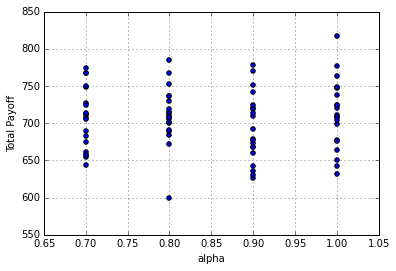

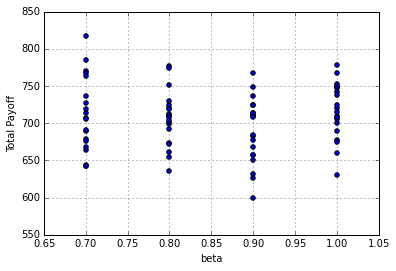

In [35]:
plt.scatter(out.alpha, out.Total_Payoff)
plt.grid(True)
plt.xlabel("alpha")
plt.ylabel("Total Payoff")
plt.show()

plt.scatter(out.beta, out.Total_Payoff)
plt.grid(True)
plt.xlabel("beta")
plt.ylabel("Total Payoff")
plt.show()